<a href="https://www.kaggle.com/code/dsptlp/canada-consumer-price-index-forecast-using-prophet?scriptVersionId=167980234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Canada Consumer Price Index (CPI) & Inflation
- The Consumer Price Index (CPI) is an indicator of changes in consumer prices experienced by Canadians. It is obtained by comparing, over time, the cost of a fixed basket of goods and services purchased by consumers.
- Forecast & Actuals

## CPI
The Consumer Price Index (CPI) represents changes in prices as experienced by Canadian consumers. It measures price change by comparing, through time, the cost of a fixed basket of goods and services. Since the basket contains goods and services of unchanging or equivalent quantity and quality, the index reflects only pure price change.

The CPI is widely used as an indicator of the change in the general level of consumer prices or the rate of inflation. Since the purchasing power of money is affected by changes in prices, the CPI is useful to all Canadians. Consumers can compare movements in the CPI to changes in their personal income to monitor and evaluate changes in their financial situation.

The CPI also has several specific applications:

(1) It is used to escalate a given dollar value, over time, to preserve the purchasing power of that value. Thus, the CPI is widely used to adjust contracted payments, such as wages, rents, leases and child or spousal support allowances. Private and public pension programs (Old Age Security and the Canada Pension Plan), personal income tax deductions, and some government social payments are also escalated using the CPI.

(2) It is used as a deflator of various economic aggregates, either of income flows, to obtain constant dollar estimates of income, or of expenditure flows, to obtain personal expenditure estimates at constant prices.

(3) It is used to set and monitor the implementation of economic policy. The Bank of Canada, for example, uses the CPI, and special aggregates of the CPI, to monitor its monetary policies.

(4) Business analysts and economists use the CPI for economic analysis and research on various issues, such as the causes and effects of inflation, and understanding regional disparities in price movements.

Price movements of the goods and services represented in the CPI are weighted according to the relative importance of goods and services in the total expenditures of consumers. Each good or service is considered to be an element in a basket representative of consumer spending, and price movements are assigned a basket share with the proportion of total consumption expenditure they account for. For example, Canadians as a whole spend a much larger share of their total expenditures on rent than on milk. As a result, a 10% price increase in rental rates will have a greater impact on the all-items CPI than a 10% increase in the price of milk. The CPI basket weights are normally updated on an annual basis; the data to derive the weights is obtained primarily from Household Final Consumption Expenditure (HFCE) series, and supplemented by data from the Survey of Household Spending (SHS). Additional data sources are used when the information supporting expenditure weights for specific aggregates is not sufficiently robust or where HFCE or SHS data is unavailable.

Enhancing the quality of the CPI is a continuous process. Following the initial introduction of point-of-sale transaction data into the food components of the CPI in May 2018, the data has become more broadly used in the food indexes. In addition, air transportation data was enhanced, web-scraped data was introduced into clothing and footwear sub-indexes, and the sample for the cellular services index was expanded.

## Inflation

### CPI-trim 
- A measure of core inflation that excludes CPI components whose rates of change in a given month are located in the tails of the distribution of price changes. This measure helps filter out extreme price movements that might be caused by factors specific to certain components. In particular, CPI-trim excludes 20 per cent of the weighted monthly price variations at both the bottom and top of the distribution of price changes, and thus it always removes 40 per cent of the total CPI basket.Note 4 These excluded components can change from month to month, depending on which are extreme at a given time. A good example would be the impact of severe weather on the prices of certain food components. This approach differs from traditional a priori exclusion-based measures (e.g., CPIX), which every month omit a pre-specified list of components from the CPI basket.

### CPI-median 
- A measure of core inflation corresponding to the price change located at the 50th percentile (in terms of the CPI basket weights) of the distribution of price changes in a given month. This measure helps filter out extreme price movements specific to certain components. This approach is similar to CPI-trim as it eliminates all the weighted monthly price variations at both the bottom and top of the distribution of price changes in any given month, except the price change for the component that is the midpoint of that distribution.

### CPI-common 
- A measure of core inflation that tracks common price changes across categories in the CPI basket. It uses a statistical procedure called a factor model to detect these common variations, which helps filter out price movements that might be caused by factors specific to certain components.

### Bank of Canada
- Bank of Canada's Preferred Measures of Core Inflation General Information Document https://www.statcan.gc.ca/en/statistical-programs/document/2301_D63_T9_V2

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import requests
import matplotlib.ticker as mtick
import math
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

## Get Data from Statistics Canada (https://www150.statcan.gc.ca/)

In [2]:
def download_csv(url, destination):
    response = requests.get(url)
    with open(destination, 'wb') as file:
        file.write(response.content)

csv_url = 'https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1810000401&latestN=0&startDate=20001001&endDate=20240201&csvLocale=en&selectedMembers=%5B%5B2%5D%2C%5B2%2C3%2C79%2C96%2C139%2C176%2C184%2C201%2C219%2C256%2C274%2C282%2C285%2C287%2C288%5D%5D&checkedLevels='
destination_path = 'data_file.csv'

download_csv(csv_url, destination_path)

df = pd.read_csv(destination_path, encoding='utf-8')
df.head(5)

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000-10,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.3,NaN,NaN,NaN,1
1,2000-11,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.6,NaN,NaN,NaN,1
2,2000-12,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.7,NaN,NaN,NaN,1
3,2001-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.3,NaN,NaN,NaN,1
4,2001-02,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,96.8,NaN,NaN,NaN,1


In [3]:
df = df.rename(columns={"REF_DATE": "ds", "VALUE": "y"})
df = df[df['Products and product groups'] == 'All-items']

df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd(0)
df.tail(5)

,ds,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,y,STATUS,SYMBOL,TERMINATED,DECIMALS
276,2023-10-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.6,NaN,NaN,NaN,1
277,2023-11-30,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.8,NaN,NaN,NaN,1
278,2023-12-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1
279,2024-01-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1
280,2024-02-29,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.8,NaN,NaN,NaN,1


## Review Actuals
- Inflation is calculated YoY Change in CPI
- Graph CPI and Inflation

In [4]:
actuals_df = df[['ds','y']]
actuals_df = actuals_df[actuals_df['ds'] >= '2019-01-31']

# Lookup value one year ago from the existing 'Date' column
actuals_df['ds_ly'] = df['ds'] - pd.DateOffset(years=1)
actuals_df

# Merge the DataFrames on the 'Key' column, specifying left and right column names
actuals_df = pd.merge(actuals_df, actuals_df, left_on='ds', right_on='ds_ly', how='inner')

actuals_df.columns = ['d1','y_ly','d2','ds','y','d3']
actuals_df = actuals_df[['ds','y','y_ly']]
actuals_df['inflation'] = 100 * (actuals_df['y'] - actuals_df['y_ly']) / actuals_df['y_ly']
actuals_df.tail(5)

,ds,y,y_ly,inflation
44,2023-10-31,158.6,153.8,3.120936
45,2023-11-30,158.8,154.0,3.116883
46,2023-12-31,158.3,153.1,3.396473
47,2024-01-31,158.3,153.9,2.858999
48,2024-02-29,158.8,154.5,2.783172


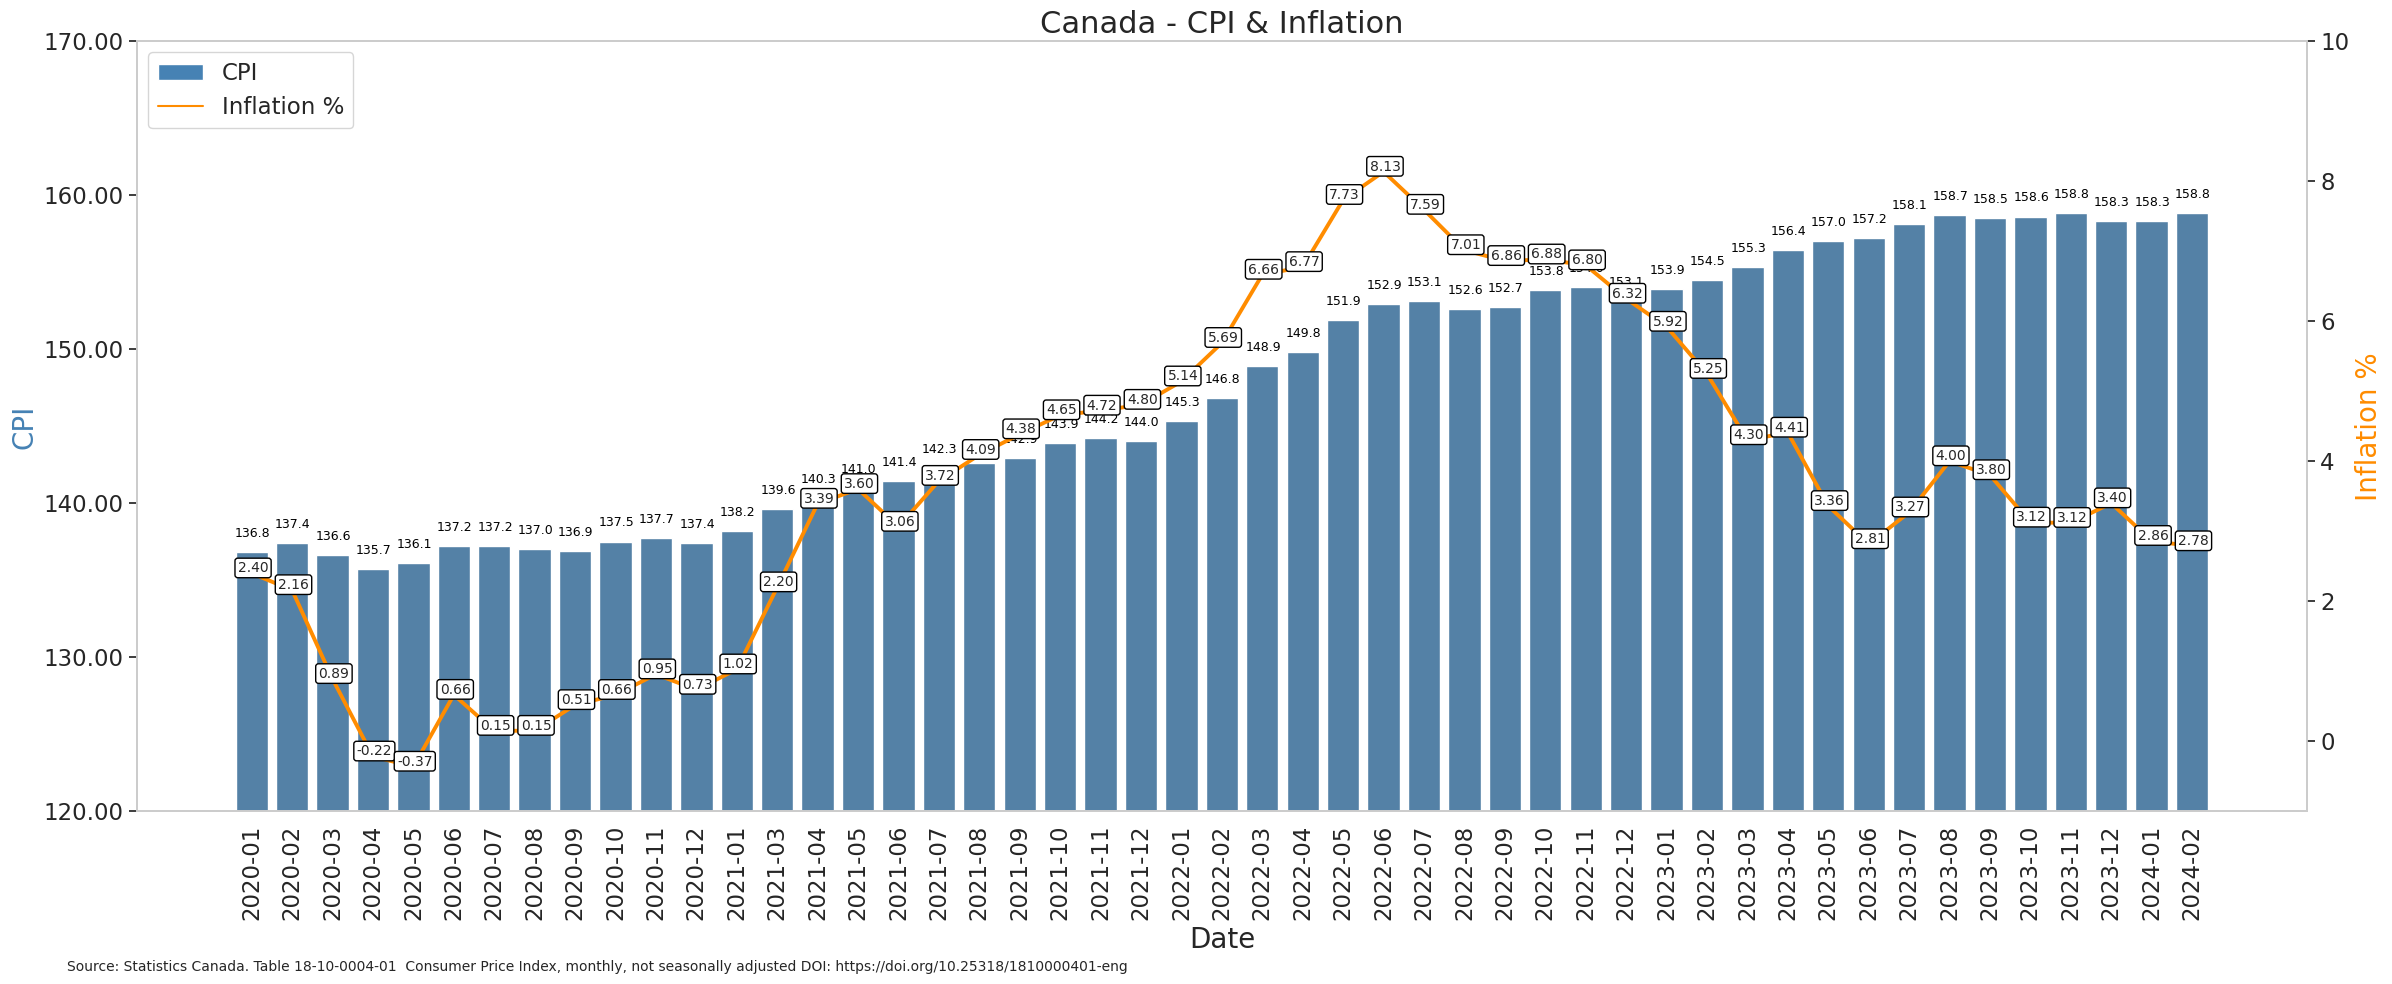

In [5]:
actuals_df['ds'] = actuals_df['ds'].astype(str)

# Create a new DataFrame with 'Index_Column' set as the index
actuals_df = actuals_df.set_index('ds')

x = actuals_df.index.tolist()
x = list(map(lambda x: x[:-3], x))
y1 = actuals_df['y']
y2 = actuals_df['inflation']

sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(28, 10),frameon =False)

plt.xticks(rotation=90)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='steelblue')
ax1.set_ylim([120, 170])
ax1.set_ylabel('CPI', color='steelblue', fontsize=20)

skip_count = 0  # Specify how many labels to skip
skip_label = 0  # Initialize skip_label counter

# Add values on top of the bars
for i, v in enumerate(y1):
    if skip_label == 0:
        ax1.text(i + 0.02, v + 1, '{:,.1f}'.format(v), color='black', ha='center',fontsize=9)
    skip_label = (skip_label + 1) % (skip_count + 1) 

ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(x=x, y=y2, ax=ax2, color='darkorange',linewidth=2.8,markers=True,markersize=11)
ax2.set_ylim([-1, 10])
ax2.set_ylabel('Inflation %', color='darkorange', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

skip_count = 0  # Specify how many labels to skip
skip_label = 0  # Initialize skip_label counter

# Add values on top of the bars
for i, v in enumerate(y2):
    if skip_label == 0:
        ax2.annotate(f'{v:,.2f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=10)     
    skip_label = (skip_label + 1) % (skip_count + 1)    

# Set x-axis label and title
ax1.set_xlabel('Date', fontsize=20)
ax1.set_title('Canada - CPI & Inflation', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['CPI', 'Inflation %']
legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),
                   Line2D([0], [0], color='darkorange', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels, loc='upper left')

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Adding a footnote below the x-axis
footnote_text = "Source: Statistics Canada. Table 18-10-0004-01  Consumer Price Index, monthly, not seasonally adjusted DOI: https://doi.org/10.25318/1810000401-eng"
plt.figtext(0.1, -0.05, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("CPI_And_Inflation.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

## Forecast Using Prophet

13:04:25 - cmdstanpy - INFO - Chain [1] start processing
13:04:25 - cmdstanpy - INFO - Chain [1] done processing


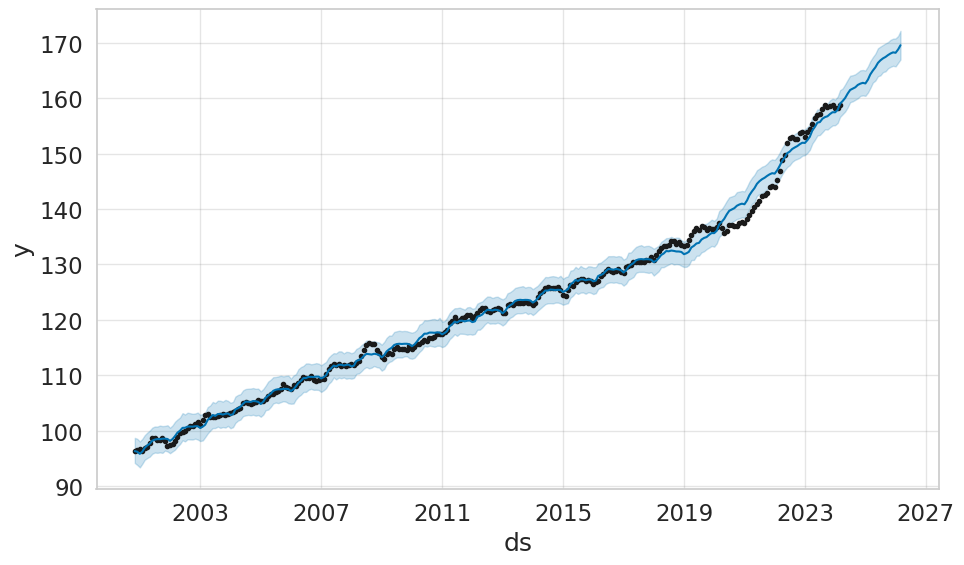

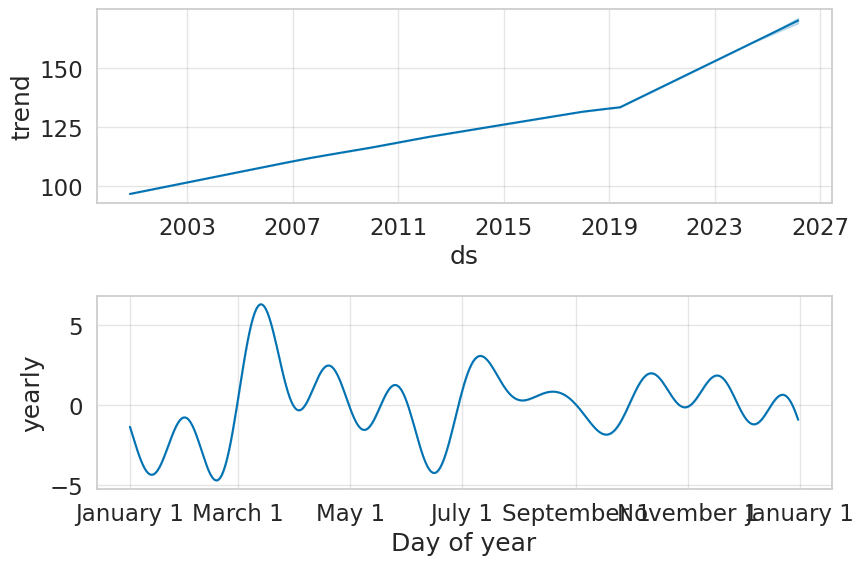

In [6]:
my_model = Prophet(interval_width=0.95,daily_seasonality=False)
my_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=24 , freq = 'ME' , include_history = 'TRUE')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

fig1 = my_model.plot(forecast)
fig2 = my_model.plot_components(forecast)

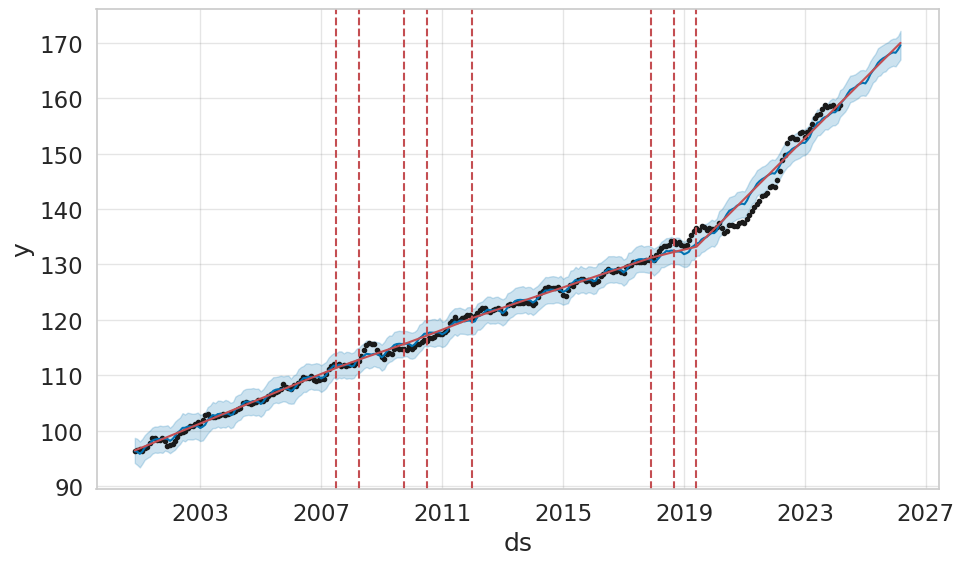

In [7]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

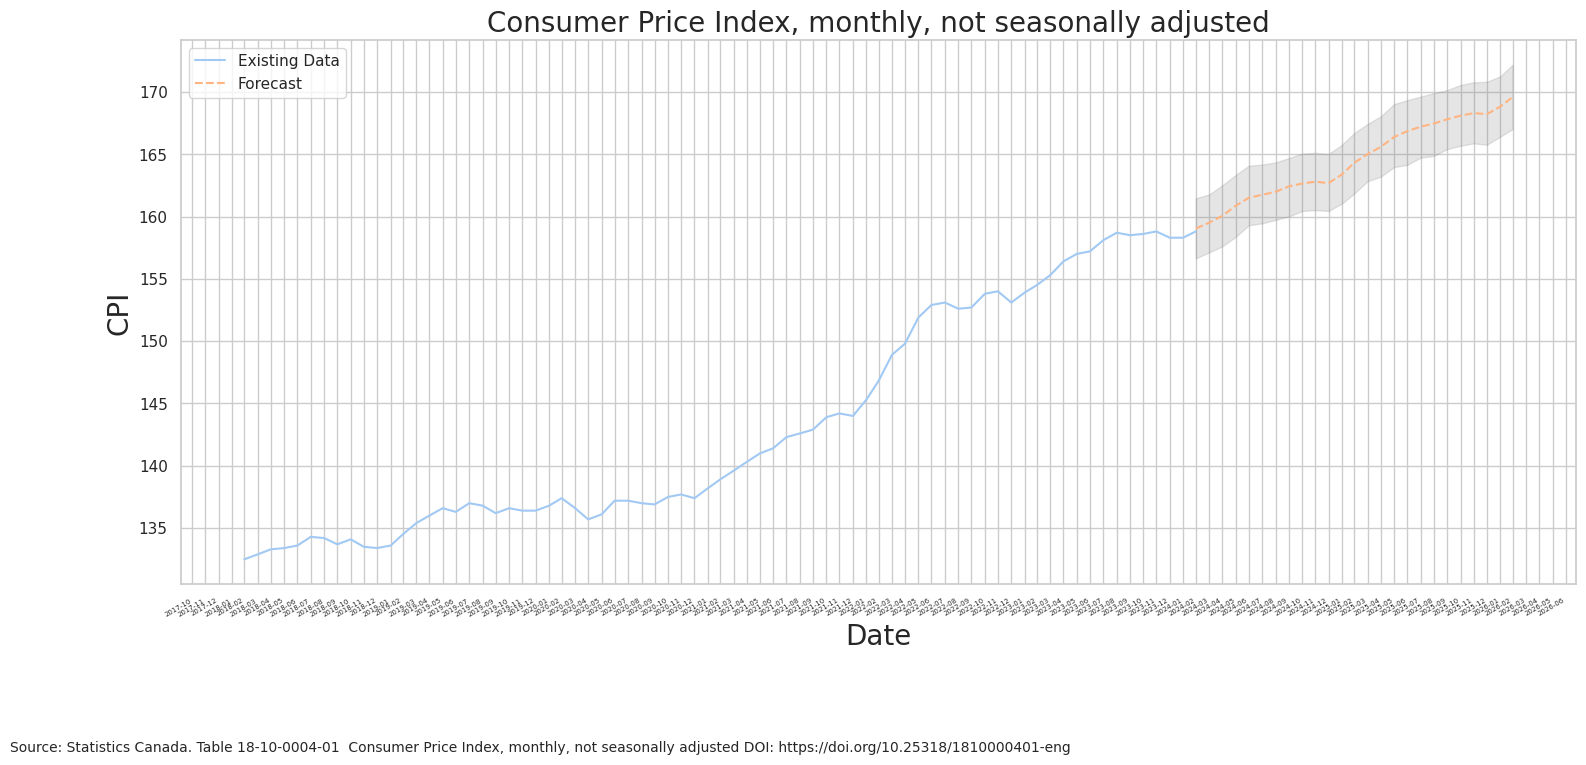

In [8]:
forecast_plot = forecast[(forecast['ds'] > '01/31/2024') ]
forecast_plot = forecast_plot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

existing_data = df[['ds', 'y']]
existing_data = existing_data[existing_data['ds'] > '01/31/2018']

# Merge the existing data with the forecast on 'ds'
merged_data = pd.merge(existing_data, forecast_plot, on='ds', how='outer')

sns.set(style="whitegrid", font_scale=1)
sns.set_palette("pastel")  # Choose a light color palette

# Plot the existing data
plt.figure(figsize=(18, 8))
sns.lineplot(x='ds', y='y', data=merged_data, label='Existing Data')

# Plot the forecast
sns.lineplot(x='ds', y='yhat', data=merged_data, label='Forecast', linestyle='dashed')

# Fill the confidence interval
plt.fill_between(merged_data['ds'], merged_data['yhat_lower'], merged_data['yhat_upper'], color='gray', alpha=0.2)

# Specify the frequency of the x-axis labels (e.g., every 2 months)
locator = mdates.MonthLocator(bymonthday=-1, interval=1)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Set x-axis label font size
plt.xticks(fontsize=5)

plt.title('Consumer Price Index, monthly, not seasonally adjusted', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('CPI', fontsize=20)
plt.legend()


footnote_text = "Source: Statistics Canada. Table 18-10-0004-01  Consumer Price Index, monthly, not seasonally adjusted DOI: https://doi.org/10.25318/1810000401-eng"
plt.figtext(0.03, -0.01, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

fig.savefig('CPI_Forecast.png',transparent=True,  bbox_inches='tight',pad_inches=0.15,dpi=400)

plt.show()

In [9]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-10-31,96.437334,94.172739,98.709675,96.437334,96.437334,-0.118350,-0.118350,-0.118350,-0.118350,-0.118350,-0.118350,0.0,0.0,0.0,96.318984
1,2000-11-30,96.622184,93.811568,98.533178,96.622184,96.622184,-0.422196,-0.422196,-0.422196,-0.422196,-0.422196,-0.422196,0.0,0.0,0.0,96.199988
2,2000-12-31,96.813195,93.372087,98.053028,96.813195,96.813195,-0.992735,-0.992735,-0.992735,-0.992735,-0.992735,-0.992735,0.0,0.0,0.0,95.820459
3,2001-01-31,97.004206,94.051663,98.538318,97.004206,97.004206,-0.759242,-0.759242,-0.759242,-0.759242,-0.759242,-0.759242,0.0,0.0,0.0,96.244964
4,2001-02-28,97.176732,94.744030,99.181194,97.176732,97.176732,-0.248828,-0.248828,-0.248828,-0.248828,-0.248828,-0.248828,0.0,0.0,0.0,96.927905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2025-10-31,168.213070,165.676364,170.553912,167.310601,169.127241,-0.124323,-0.124323,-0.124323,-0.124323,-0.124323,-0.124323,0.0,0.0,0.0,168.088747
301,2025-11-30,168.660935,165.864553,170.761606,167.654382,169.636749,-0.368943,-0.368943,-0.368943,-0.368943,-0.368943,-0.368943,0.0,0.0,0.0,168.291992
302,2025-12-31,169.123729,165.760137,170.808095,168.087296,170.160929,-0.907239,-0.907239,-0.907239,-0.907239,-0.907239,-0.907239,0.0,0.0,0.0,168.216491
303,2026-01-31,169.586524,166.416788,171.254294,168.499094,170.684740,-0.757214,-0.757214,-0.757214,-0.757214,-0.757214,-0.757214,0.0,0.0,0.0,168.829310
